# Basket Size Prediction

The goal here is to predict the number of reorders in the next basket for each user.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from constants import *
from helpers import evaluate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50

/Users/lukelefebure/anaconda/lib/python2.7/site-packages/traitlets/traitlets.py:811: DeprecationWarning: A parent of InlineBackend._config_changed has adopted the new (traitlets 4.1) @observe(change) API
  clsname, change_or_name), DeprecationWarning)


### Build Training/Test Sets

In [2]:
train = pd.read_pickle(TRAIN)
test = pd.read_pickle(TEST)

In [3]:
train.head()

,user_id,order_id,product_id,eval_set,u_days_since_prior_order_mean,u_days_since_prior_order_median,u_total_orders_max,u_prev_order_dow,u_prev_days_since_prior_order,u_prev_order_size,u_prev_reorder_size,u_prev_order_reorder_rate,u_basket_size,u_reorder_rate_after_first_order,u_products_nunique,u_products_count,u_total_reorders_sum,pr_add_to_cart_order_mean,pr_order_count,pr_reordered_sum,pr_reordered_mean,o_days_since_prior_order,o_dow,up_add_to_cart_order_mean,up_add_to_cart_order_median,up_order_number_min,up_order_number_max,up_reorder_count,up_days_between_orders_last,up_days_between_orders_mean,up_days_between_orders_median,up_days_since_last_order,pr_reorder_times,pr_reorder_prob,o_same_dow,u_products_ratio,up_days_between_orders_diff_last,up_days_between_orders_diff_mean,up_days_between_orders_diff_median,up_order_number_gap,up_orders_since_last_order,up_reorder_rate,up_reorder_rate_since_first,ordered
0,1,1187899,196,train,19.555556,20.0,10,4,30,9,6,0.666667,5.900000,0.784259,18,59,41,3.721774,35791,27791,0.77648,14,4,1.400000,1,1,10,10,30,19.555556,20,14,4.473875,0.5825,True,0.305085,-16,-5.555556,-6,9,0,1.000000,1.000000,1
1105,21,1854765,196,train,9.906250,7.5,33,1,30,14,4,0.285714,6.212121,0.571691,102,205,103,3.721774,35791,27791,0.77648,28,1,2.000000,2,10,10,1,NaN,NaN,NaN,252,4.473875,0.5825,True,0.497561,NaN,NaN,NaN,0,23,0.030303,0.000000,0
2632,43,1864787,196,train,10.400000,9.5,11,0,9,14,7,0.500000,13.363636,0.401243,88,147,59,3.721774,35791,27791,0.77648,26,5,5.000000,5,6,9,2,NaN,NaN,NaN,50,4.473875,0.5825,False,0.598639,NaN,NaN,NaN,3,2,0.181818,0.200000,0
3022,52,1647290,196,train,9.076923,7.5,27,1,10,11,8,0.727273,6.259259,0.722805,51,169,118,3.721774,35791,27791,0.77648,3,4,4.285714,4,1,21,14,8,8.142857,7,69,4.473875,0.5825,False,0.301775,-5,-5.142857,-4,20,6,0.518519,0.500000,0
4134,67,2757217,196,train,7.565217,7.0,24,2,1,2,1,0.500000,3.375000,0.761594,23,81,58,3.721774,35791,27791,0.77648,5,0,1.421053,1,1,23,19,14,8.071429,7,6,4.473875,0.5825,False,0.283951,-9,-3.071429,-2,22,1,0.791667,0.782609,1


In [4]:
user_feature_list = ["u_days_since_prior_order_mean", "u_days_since_prior_order_median", 
                     "u_total_orders_max", "u_prev_order_dow", "u_prev_days_since_prior_order",
                     "u_prev_order_size", "u_prev_reorder_size", "u_prev_order_reorder_rate", 
                     "u_basket_size", "u_reorder_rate_after_first_order", 
                     "u_products_nunique", "u_products_count", "u_total_reorders_sum", 
                     "o_days_since_prior_order", "o_dow", "o_same_dow", "u_products_ratio"]

In [5]:
reorder_count_training = (train
                          .groupby("user_id").agg({
                              "ordered": "sum"
                          })
                          .join(train.set_index("user_id")[user_feature_list])
                          .drop_duplicates())

In [6]:
reorder_count_test = test.set_index("user_id")[user_feature_list].drop_duplicates()

### Exploratory

In [20]:
reorder_count_training.head()

,ordered,u_days_since_prior_order_mean,u_days_since_prior_order_median,u_total_orders_max,u_prev_order_dow,u_prev_days_since_prior_order,u_prev_order_size,u_prev_reorder_size,u_prev_order_reorder_rate,u_basket_size,u_reorder_rate_after_first_order,u_products_nunique,u_products_count,u_total_reorders_sum,o_days_since_prior_order,o_dow,o_same_dow,u_products_ratio
user_id,,,,,,,,,,,,,,,,,,
1,10,19.555556,20,10,4,30,9,6,0.666667,5.900000,0.784259,18,59,41,14,4,True,0.305085
2,12,15.230769,13,14,3,13,16,10,0.625000,13.928571,0.482419,102,195,93,30,1,False,0.523077
5,4,13.333333,11,4,1,19,12,8,0.666667,9.250000,0.503704,23,37,14,6,0,False,0.621622
7,8,10.684211,7,20,3,7,12,12,1.000000,10.300000,0.793953,68,206,138,6,2,False,0.330097
8,4,30.000000,30,3,5,30,13,5,0.384615,16.333333,0.458974,36,49,13,10,1,False,0.734694


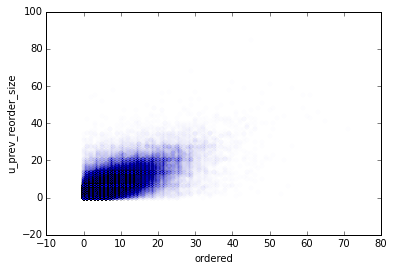

In [43]:
(reorder_count_training
.plot(x = "ordered", y = "u_prev_reorder_size", kind = "scatter", alpha = .008))

### Model

In [77]:
rf = RandomForestRegressor()

In [78]:
params = {
    "n_estimators": [50, 100],
    "max_depth": [4, 8]
}

In [91]:
model = GridSearchCV(rf, params, scoring='mean_squared_error')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    reorder_count_training.drop("ordered", axis = 1).values, 
    reorder_count_training.ordered.values, test_size=0.25, random_state=42)

In [92]:
model.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100], 'max_depth': [4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='mean_squared_error', verbose=0)

In [93]:
pd.DataFrame(model.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,7.093583,0.125363,-16.329543,-16.094962,4,50,"{u'n_estimators': 50, u'max_depth': 4}",3,-16.632859,-16.088206,-16.087291,-16.032389,-16.268468,-16.164292,0.544092,0.004110,0.226876,0.054061
1,12.886482,0.204649,-16.331423,-16.110360,4,100,"{u'n_estimators': 100, u'max_depth': 4}",4,-16.635765,-16.104637,-16.130150,-16.085388,-16.228347,-16.141057,0.036912,0.000969,0.218907,0.023084
2,11.787352,0.182723,-14.927842,-13.329311,8,50,"{u'n_estimators': 50, u'max_depth': 8}",2,-15.053407,-13.289659,-14.902561,-13.345613,-14.827553,-13.352661,0.023692,0.004372,0.093922,0.028186
3,54.932887,0.330067,-14.893620,-13.308521,8,100,"{u'n_estimators': 100, u'max_depth': 8}",1,-15.041383,-13.275428,-14.846463,-13.302408,-14.793011,-13.347727,44.398129,0.013883,0.106740,0.029831


In [94]:
val_preds = model.predict(X_test)

In [95]:
mean_squared_error(y_test, val_preds)

14.683820043954979

Compare with xgboost:

In [9]:
params = {
    "objective": "reg:linear",
    "eta": .03,
    "max_depth": 6
}
xgb_model = xgb.train(
    params,
    xgb.DMatrix(X_train, label = y_train, 
                feature_names = reorder_count_training.drop("ordered", axis = 1).columns), 
    num_boost_round = 200)

In [10]:
xgb_val_preds = xgb_model.predict(xgb.DMatrix(X_test, label = y_test, 
                                  feature_names = reorder_count_training.drop("ordered", axis = 1).columns))

In [11]:
mean_squared_error(y_test, xgb_val_preds)

14.176094930704149

### Prediction on Test

In [12]:
xgb_model = xgb.train(
    params,
    xgb.DMatrix(reorder_count_training.drop("ordered", axis = 1).values, 
                label = reorder_count_training.ordered.values, 
                feature_names = reorder_count_training.drop("ordered", axis = 1).columns), 
    num_boost_round = 200)

In [13]:
preds = xgb_model.predict(
    xgb.DMatrix(reorder_count_test.values, 
                feature_names = reorder_count_test.columns))

In [14]:
test_basket_preds = reorder_count_test.assign(reorder_size_prediction = preds)[["reorder_size_prediction"]]
test_basket_preds.head()

,reorder_size_prediction
user_id,
15,2.613823
19,12.518693
31,8.843174
98,2.384459
290,28.187294


In [15]:
test_basket_preds.to_pickle(BASKET_SIZE)